<a href="https://colab.research.google.com/github/Auhre/Global-Inflation-Prediction-with-LSTM/blob/main/Global_Inflation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Table of Contents**

1.   Overview
2.   Dataset
3.   Feature Engineering
  *   Cleaning
  *   Transforming
4.   Model Development

  *   Architecture
  *   Training
  *   Evaluation
5.   Output Predictions








# **1. Overview**

The goal of this small project casted on a notebook is to make a prediction model (forecasting) for aspects of inflation globally having it observed in the past 5 decades. Since traditional model such as ARIMA works only with univariate and for this case is in the concern of multivariate, and thus will be utilizing deep learning approach such as LSTM (Long short term memory) architecture for the model to capture pattern and make predictions.

In [1]:
# Here are the tools needed for the project
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer, Input
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# **2. Dataset**


The dataset consist of records from 211 countries with inflation data yearly dating back throughout 1970 to 2022. The aspect of inflation is presented with:

*   Headline Consumer Price Inflation
*   Energy Consumer Price Inflation
*   Food Consumer Price Inflation
*   Official Core Consumer Price Inflation
*   Producer Price Inflation

and will be considered as the variables to predict in the next 4 years of inflation.

---


Source: [Global Inflation Dataset](https://www.kaggle.com/datasets/belayethossainds/global-inflation-dataset-212-country-19702022?resource=download)






In [2]:
# Load dataset
data = pd.read_csv('global_inflation.csv', encoding='latin-1')
data

,Country Code,IMF Country Code,Country,Indicator Type,Series Name,1970,1971,1972,1973,1974,...,2019,2020,2021,2022,Note,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63
0,ABW,314.0,Aruba,Inflation,Headline Consumer Price Inflation,NaN,NaN,NaN,NaN,NaN,...,4.26,1.22,0.74,6.04,Annual average inflation,NaN,NaN,NaN,NaN,NaN
1,AFG,512.0,Afghanistan,Inflation,Headline Consumer Price Inflation,25.51,25.51,-12.52,-10.68,10.23,...,2.30,5.44,5.06,NaN,Annual average inflation,NaN,NaN,NaN,NaN,NaN
2,AGO,614.0,Angola,Inflation,Headline Consumer Price Inflation,7.97,5.78,15.80,15.67,27.42,...,17.08,21.02,23.85,21.35,Annual average inflation,NaN,NaN,NaN,NaN,NaN
3,ALB,914.0,Albania,Inflation,Headline Consumer Price Inflation,NaN,NaN,NaN,NaN,NaN,...,1.41,1.62,2.04,6.73,Annual average inflation,NaN,NaN,NaN,NaN,NaN
4,ARE,466.0,United Arab Emirates,Inflation,Headline Consumer Price Inflation,21.98,21.98,21.98,21.98,21.98,...,-1.93,-2.08,0.18,5.22,Annual average inflation,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,VEN,299.0,"Venezuela, RB",Inflation,Producer Price Inflation,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"Producer Price Index, All Commodities",NaN,NaN,NaN,NaN,NaN
779,VNM,582.0,Vietnam,Inflation,Producer Price Inflation,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"Producer Price Index, All Commodities",NaN,NaN,NaN,NaN,NaN
780,XKX,967.0,Kosovo,Inflation,Producer Price Inflation,NaN,NaN,NaN,NaN,NaN,...,0.93,-0.58,4.92,NaN,"Producer Price Index, All Commodities",NaN,NaN,NaN,NaN,NaN
781,ZAF,199.0,South Africa,Inflation,Producer Price Inflation,NaN,5.00,6.35,12.44,18.58,...,4.62,2.49,7.12,14.36,"Producer Price Index, All Commodities",NaN,NaN,NaN,NaN,NaN


# **3. Feature Engineering**

Feature Engineering follows a series of steps within Cleaning and Trasforming the data prior to model training with LSTM.

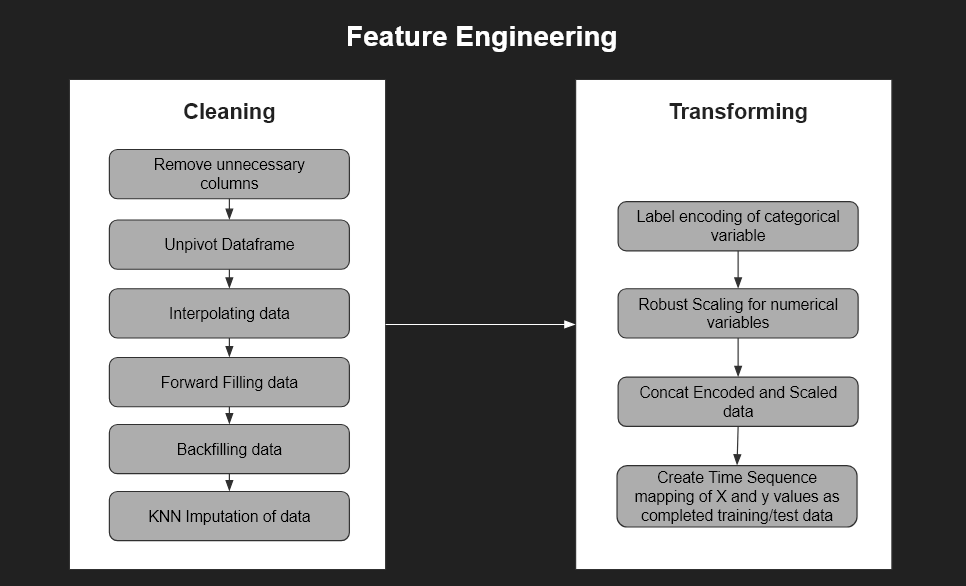

### A. Cleaning

Column that is not necessary to be included are removed from the dataset. Then the dataframe is unpivotted to transform the dataset into a long format. The dataframe then is checked for missing values count and after undergoes the process of interpolation, backfilling, forward filling and imputation, to handle these missing data. Line plot is then provided in comparison of inflation data before and after handling the missing values in country basis. Soon after is the fixing the order of column from the dataframe for convenience as well as copying the cleaned dataframe onto another.

In [3]:
# Remove Unnamed columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,Country Code,IMF Country Code,Country,Indicator Type,Series Name,1970,1971,1972,1973,1974,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Note
0,ABW,314.0,Aruba,Inflation,Headline Consumer Price Inflation,NaN,NaN,NaN,NaN,NaN,...,0.42,0.48,-0.89,-0.47,3.58,4.26,1.22,0.74,6.04,Annual average inflation
1,AFG,512.0,Afghanistan,Inflation,Headline Consumer Price Inflation,25.51,25.51,-12.52,-10.68,10.23,...,4.67,-0.66,4.38,4.98,0.63,2.30,5.44,5.06,NaN,Annual average inflation
2,AGO,614.0,Angola,Inflation,Headline Consumer Price Inflation,7.97,5.78,15.80,15.67,27.42,...,7.30,9.16,32.38,29.84,19.63,17.08,21.02,23.85,21.35,Annual average inflation
3,ALB,914.0,Albania,Inflation,Headline Consumer Price Inflation,NaN,NaN,NaN,NaN,NaN,...,1.62,1.91,1.29,1.99,2.03,1.41,1.62,2.04,6.73,Annual average inflation
4,ARE,466.0,United Arab Emirates,Inflation,Headline Consumer Price Inflation,21.98,21.98,21.98,21.98,21.98,...,2.34,4.07,1.62,1.97,3.06,-1.93,-2.08,0.18,5.22,Annual average inflation


In [4]:
# Remove unnecessary extra columns
data = data.drop(['Country Code', 'IMF Country Code', 'Indicator Type', 'Note'], axis=1)
data.head()

,Country,Series Name,1970,1971,1972,1973,1974,1975,1976,1977,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,Headline Consumer Price Inflation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.37,0.42,0.48,-0.89,-0.47,3.58,4.26,1.22,0.74,6.04
1,Afghanistan,Headline Consumer Price Inflation,25.51,25.51,-12.52,-10.68,10.23,11.85,0.60,7.65,...,7.39,4.67,-0.66,4.38,4.98,0.63,2.30,5.44,5.06,NaN
2,Angola,Headline Consumer Price Inflation,7.97,5.78,15.80,15.67,27.42,29.00,80.70,69.01,...,8.78,7.30,9.16,32.38,29.84,19.63,17.08,21.02,23.85,21.35
3,Albania,Headline Consumer Price Inflation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.93,1.62,1.91,1.29,1.99,2.03,1.41,1.62,2.04,6.73
4,United Arab Emirates,Headline Consumer Price Inflation,21.98,21.98,21.98,21.98,21.98,21.98,21.98,21.97,...,1.09,2.34,4.07,1.62,1.97,3.06,-1.93,-2.08,0.18,5.22


In [5]:
# Unpivot dataframe
data_melt = pd.melt(data, id_vars=['Country', 'Series Name'], var_name='Year', value_name='Inflation')
data_melt.head()

,Country,Series Name,Year,Inflation
0,Aruba,Headline Consumer Price Inflation,1970,NaN
1,Afghanistan,Headline Consumer Price Inflation,1970,25.51
2,Angola,Headline Consumer Price Inflation,1970,7.97
3,Albania,Headline Consumer Price Inflation,1970,NaN
4,United Arab Emirates,Headline Consumer Price Inflation,1970,21.98


In [6]:
# Check for null counts
data_melt['Inflation'].isnull().sum()

11323

In [7]:
# Fill in data through interpolation, backfill and forwardfill
data_melt['Inflation-interpolated'] = data_melt.groupby(['Country', 'Series Name'])['Inflation'].transform(lambda x: x.interpolate(method='polynomial', order=1))
data_melt['Inflation-interpolated'] = data_melt['Inflation-interpolated'].bfill()
data_melt['Inflation-interpolated'] = data_melt['Inflation-interpolated'].ffill()

In [8]:
# Reshape the data for KNN imputation
imputation_data =  data_melt.pivot_table(index=['Country', 'Year'], columns='Series Name', values='Inflation-interpolated').reset_index()

# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=15)

# Include encoded country code to imputer variables
le_imputer = LabelEncoder()
imputation_data['Country_Encoded'] = le_imputer.fit_transform(imputation_data['Country'])

# Fit and transform the data to fill missing values
imputed_data = imputer.fit_transform(imputation_data.drop(['Year', 'Country'], axis=1))

# Create a new DataFrame with imputed values
imputed_df = pd.DataFrame(imputed_data, columns=imputation_data.columns[2:])
imputed_df['Country'] = imputation_data['Country']
imputed_df['Year'] = imputation_data['Year']

# Melt the DataFrame back to the original format
imputed_melt = pd.melt(imputed_df, id_vars=['Country', 'Year', 'Country_Encoded'], var_name='Series Name', value_name='Inflation-KNN')
imputed_df

Series Name,Energy Consumer Price Inflation,Food Consumer Price Inflation,Headline Consumer Price Inflation,Official Core Consumer Price Inflation,Producer Price Inflation,Country_Encoded,Country,Year
0,-0.20,16.50,25.51,5.028000,277.305333,0.0,Afghanistan,1970
1,25.90,16.50,25.51,-10.910000,12.372667,0.0,Afghanistan,1971
2,6.70,41.70,-12.52,6.340000,66.113333,0.0,Afghanistan,1972
3,39.90,63.10,-10.68,8.560000,71.586000,0.0,Afghanistan,1973
4,9.40,55.20,10.23,15.550000,61.582667,0.0,Afghanistan,1974
...,...,...,...,...,...,...,...,...
11178,0.99,14.59,10.61,321.060667,11.447333,210.0,Zimbabwe,2018
11179,90.81,86.12,255.29,3.390667,71.179333,210.0,Zimbabwe,2019
11180,306.43,601.02,557.21,3.203062,69.306667,210.0,Zimbabwe,2020
11181,69.82,105.80,98.55,33.242667,90.172000,210.0,Zimbabwe,2021


In [9]:
# Plot to compare data before and after imputation, interpolation, backfill, forwardfill
def before_and_after_interpolation_imputation(country):
  # Set the color map for the aspects of inflation
  color_map = {
      'Energy Consumer Price Inflation': 'red',
      'Headline Consumer Price Inflation': 'blue',
      'Food Consumer Price Inflation': 'green',
      'Official Core Consumer Price Inflation': 'orange',
      'Producer Price Inflation': 'purple'
  }
  # Plot data points before imputation, interpolation, backfill, forwardfill
  fig1 = px.line(data_melt[data_melt['Country'] == country], x="Year", y="Inflation", color='Series Name', color_discrete_map=color_map, markers=True, title='Inflation Rate Over Time by Country Before Interpolation and Imputation')
  fig1.show()
  # Plot data points after imputation, interpolation, backfill, forwardfill
  fig2 = px.line(imputed_melt[imputed_melt['Country'] == country], x="Year", y="Inflation-KNN", color='Series Name', color_discrete_map=color_map, markers=True, title='Inflation Rate Over Time by Country After Interpolation and Imputation')
  fig2.show()

In [10]:
# Reorder columns to place 'Country' and 'Year' first
new_column_order = ['Country', 'Year'] + [col for col in imputed_df.columns if col not in ['Country', 'Year']]
imputed_df = imputed_df[new_column_order]

imputed_df.head()

Series Name,Country,Year,Energy Consumer Price Inflation,Food Consumer Price Inflation,Headline Consumer Price Inflation,Official Core Consumer Price Inflation,Producer Price Inflation,Country_Encoded
0,Afghanistan,1970,-0.2,16.5,25.51,5.028,277.305333,0.0
1,Afghanistan,1971,25.9,16.5,25.51,-10.910,12.372667,0.0
2,Afghanistan,1972,6.7,41.7,-12.52,6.340,66.113333,0.0
3,Afghanistan,1973,39.9,63.1,-10.68,8.560,71.586000,0.0
4,Afghanistan,1974,9.4,55.2,10.23,15.550,61.582667,0.0


In [11]:
# Copy imputed dataframe into a new dataframe
data = imputed_df.copy()
data = data.drop(['Country_Encoded'], axis=1)
data.head()

Series Name,Country,Year,Energy Consumer Price Inflation,Food Consumer Price Inflation,Headline Consumer Price Inflation,Official Core Consumer Price Inflation,Producer Price Inflation
0,Afghanistan,1970,-0.2,16.5,25.51,5.028,277.305333
1,Afghanistan,1971,25.9,16.5,25.51,-10.910,12.372667
2,Afghanistan,1972,6.7,41.7,-12.52,6.340,66.113333
3,Afghanistan,1973,39.9,63.1,-10.68,8.560,71.586000
4,Afghanistan,1974,9.4,55.2,10.23,15.550,61.582667


### B. Transforming

Features are scaled and encoded in order to properly fit in the dataset into the model. Label Encoder is used to encode categorical data of country into numerical value and Robust Scaler is used to scale numerical data since Robust Scaler seems to align more with this data. This encoded values and the scaled values are appended to provide the whole preprocessed data for model training. Then the encoder and scaler fitted to our data are saved using pickle to make sure of proper transformation of test data that was used in the train data as well as inverse transformation to revert back to actual range and format of data. Then preprocess data is then utilize to provide a time series mapping of X and y values such as X would be a sequence of values prior to y value.

But before that, to show that Robust Scaler is the scaling method to be considered in the data, the distribution of the inflation data is plotted. Since the data is skewed, Robust Scaler is consider well suited for this as it is less sensitive to outliers compared to other scaling method, and is more efficient in terms of scaling.

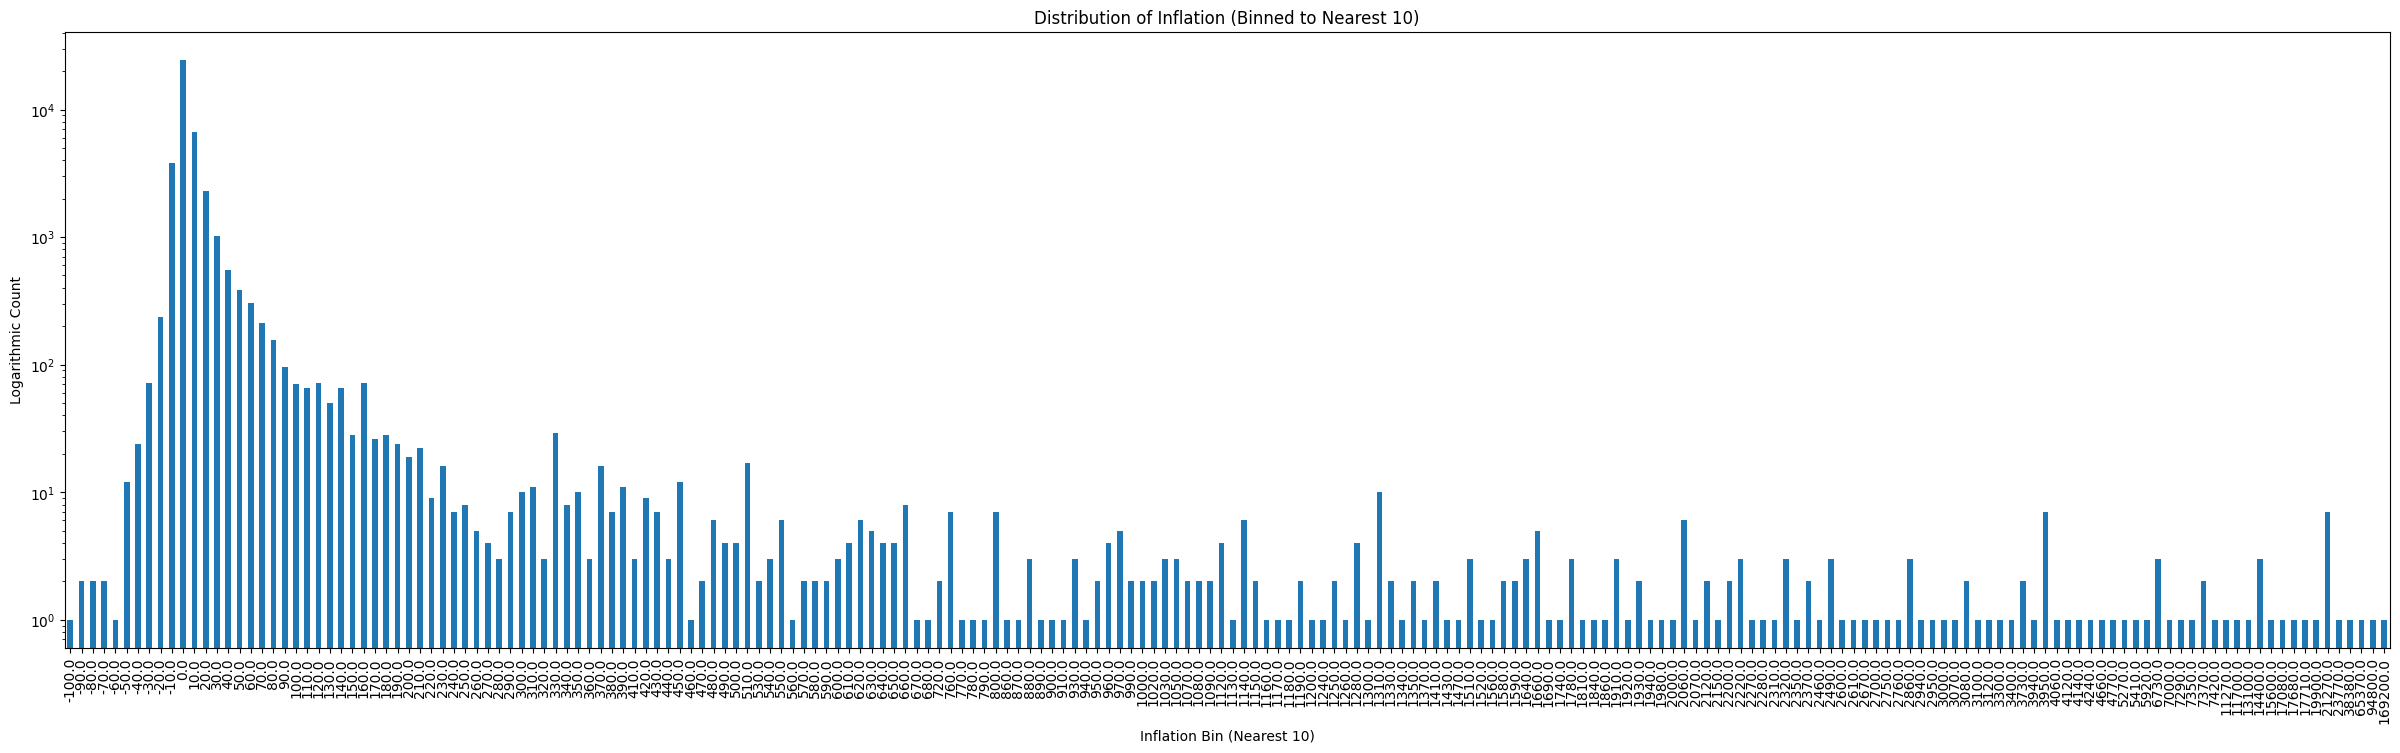

In [12]:
# Merge imputed values back into the original DataFrame
rev_data_melt = data_melt.merge(imputed_melt, on=['Country', 'Year', 'Series Name'], how='left')

# Binning the 'Inflation-KNN' column to the nearest 10s
rev_data_melt['Inflation-KNN-Binned'] = (rev_data_melt['Inflation-KNN'] // 10) * 10

# Plotting the value counts with a logarithmic y-axis
plt.figure(figsize=(30, 8))
rev_data_melt['Inflation-KNN-Binned'].value_counts().sort_index().plot(kind='bar')
plt.yscale('log')
plt.xlabel('Inflation Bin (Nearest 10)')
plt.ylabel('Logarithmic Count')
plt.title('Distribution of Inflation (Binned to Nearest 10)')
plt.show()

In [13]:
# Encode country name into Label Encoder
encoder = LabelEncoder()
country_encoded = encoder.fit_transform(data['Country'])
country_encoded

array([  0,   0,   0, ..., 210, 210, 210])

In [14]:
# Scale inflation data with RobustScaler
scaler = RobustScaler()
numeric_data_scaled = scaler.fit_transform(data.iloc[:, 2:])
numeric_data_scaled

array([[-4.76545048e-01,  7.68000000e-01,  1.81623134e+00,
         1.03830645e-01,  3.03544954e+01],
       [ 1.46686523e+00,  7.68000000e-01,  1.81623134e+00,
        -2.57392473e+00,  7.77314677e-01],
       [ 3.72300819e-02,  2.78400000e+00, -1.73134328e+00,
         3.24260753e-01,  6.77694254e+00],
       ...,
       [ 2.23551750e+01,  4.75296000e+01,  5.14151119e+01,
        -2.02778517e-01,  7.13344745e+00],
       [ 4.73715562e+00,  7.91200000e+00,  8.62966418e+00,
         4.84419803e+00,  9.46286097e+00],
       [ 3.19210722e+00,  4.51280000e+00,  2.60167910e+01,
        -2.54189807e-01,  6.32435249e+00]])

In [15]:
# Concatenate encoded and scaled array
combined_data = np.concatenate((country_encoded.reshape(-1, 1), numeric_data_scaled), axis=1)
combined_data[4]

array([0.        , 0.23827252, 3.864     , 0.39085821, 1.87163978,
       6.27113724])

In [16]:
# Save encoder and scaler into pickle format
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [17]:
# Create sequence data mapping for time series with 4 timestep
year_timestep = 4

def create_sequencese(data, sequence_length=year_timestep):
    # Provide mapping of X and y such that X is the sequence of previous timesteps and y as the sequence of latter timestep
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Create sequences data mapping
X, y = create_sequencese(combined_data)
y

array([[ 0.00000000e+00,  2.38272524e-01,  3.86400000e+00,
         3.90858209e-01,  1.87163978e+00,  6.27113724e+00],
       [ 0.00000000e+00,  1.36262100e+00,  6.56000000e-01,
         5.41977612e-01,  1.94556452e+00,  8.38195892e-02],
       [ 0.00000000e+00,  3.75651526e+01,  1.44640000e+01,
        -5.07462687e-01,  1.56250000e+00, -1.06653766e-01],
       ...,
       [ 2.10000000e+02,  2.23551750e+01,  4.75296000e+01,
         5.14151119e+01, -2.02778517e-01,  7.13344745e+00],
       [ 2.10000000e+02,  4.73715562e+00,  7.91200000e+00,
         8.62966418e+00,  4.84419803e+00,  9.46286097e+00],
       [ 2.10000000e+02,  3.19210722e+00,  4.51280000e+00,
         2.60167910e+01, -2.54189807e-01,  6.32435249e+00]])

# **4. Model Development**

LSTM architecture is the candidate model for this and LSTM is improvised RNN, able to handle forecasting predictions having the following characteristics:


*   learn relationship between multiple variables
*   has memory cell for long-term dependencies
*   mitigates vanishing and exploding gradient problem
*   adaptability to non-stationary time series
*   efficient for sequential data





### A. Model Architecture

The model consist of 3 layers, input layer and hidden layer of 50 neurons and activation function of 'relu', and a single output layer. These layers have penalites in it as L2 regulations to prevent overfitting to the data. Learning rate would be 'adaptive moment estimation' and loss function would be 'mean absolute error'.

In [18]:
# Provide train test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Build the LSTM model with L2 regularization
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, activation='relu',  return_sequences=True, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(LSTM(50, activation='relu',  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(y_train.shape[1], kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# Compile model with adam optimizer and mean absolute error on loss function
model.compile(optimizer='adam', loss='mae')

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4, 50)               │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,906 (124.63 KB)

 Trainable params: 31,906 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

### B. Model Training

Model training is done with batch training of 64 and an epoch of 50. Training loss and validation loss is plotted at every epoch of the training.

In [19]:
# Model fitting with the dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 13.9924 - val_loss: 8.2724
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 3.0444 - val_loss: 7.4902
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.5371 - val_loss: 7.2609
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.6888 - val_loss: 6.9860
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.3515 - val_loss: 6.6312
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.0192 - val_loss: 6.6498
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.9644 - val_loss: 6.5718
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2063 - val_loss: 6.4561
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9706 - val_loss: 6.3747
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8737 - val_loss: 6.2478
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.1403 - val_loss: 6.3864
Epoch 12/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s

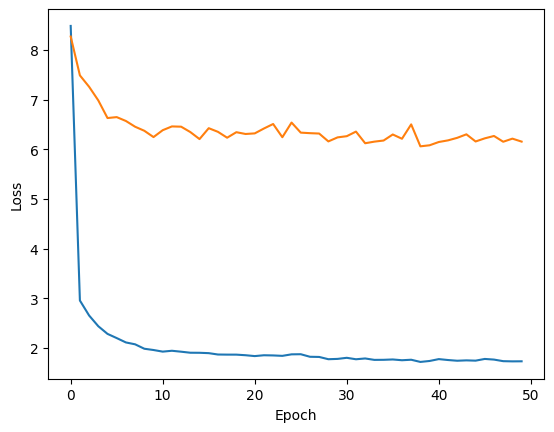

In [20]:
# Plotting loss and validation loss through training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### C. Model Evaluation

The model evaluation from the test data with mean absolute error as loss function

In [21]:
# Evaulating model
loss = model.evaluate(X_test, y_test)
loss

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8185


6.156538486480713

# **5. Output Predictions**

Will be providing prediction of aspects of inflation (value) globally for the next 4 years having a significance of timestep of 4 years, meaning last 4 years is only considered for predicting the next year. Although you can specify the timestep and number of years for prediction but predicting the next 4 years and using the previous 4 years as predictors to these variables are significant enough.

In [22]:
# Prediction of 4 years data for inflation aspect per country basis
def predict_4years(country, year_timestep=4):

  # Load the encoder and scaler pickle file for transformation
  with open('encoder.pkl', 'rb') as f:
    loaded_encoder = pickle.load(f)
  with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

  # Sample the data on country basis
  predictor = data[data['Country'] == country]

  # Provide the output dataframe
  output_df_predictions = predictor.copy()
  output_df_predictions['data fact'] = 'actual data'

  # Get latest year from the country data
  latest_year = int(predictor['Year'].max())

  # Loop 4 times to provide prediction to the next 4 years
  for _ in range(4):

    # Increment year
    latest_year = latest_year + 1

    # Subset data into the determined timestep
    predictor = predictor.iloc[-year_timestep:, :]

    # Encode and scale the subset data based from the loading encoder and scaler
    predictor_country_encoded = loaded_encoder.transform(predictor['Country'])
    predictor_numeric_data_scaled = loaded_scaler.transform(predictor.iloc[:, 2:])

    # Combined the encoded and scaled to provide a more complete predictor of data
    combined_predictor_scaled_data = np.concatenate((predictor_country_encoded.reshape(-1, 1), predictor_numeric_data_scaled), axis=1)
    combined_predictor_scaled_data = combined_predictor_scaled_data.reshape(1, combined_predictor_scaled_data.shape[0], combined_predictor_scaled_data.shape[1])

    # Predict the data using the model
    predictions = model.predict(combined_predictor_scaled_data)

    # Scale back the predicted data
    predictor_numeric_data = loaded_scaler.inverse_transform(predictions[:, 1:])

    # Concat the new data into the output dataframe
    new_row_output = np.hstack((np.array([country, latest_year]).reshape(1, 2), predictor_numeric_data[:, :]))
    output_df_predictions = pd.concat([output_df_predictions, pd.DataFrame(np.hstack((new_row_output, np.array(['predicted data']).reshape(1, 1))), columns=output_df_predictions.columns)], ignore_index=True)

    # Concat the new data into the predictor dataframe
    new_row_predictor = np.hstack((np.array([country, latest_year]).reshape(1, 2), predictor_numeric_data[:, :]))
    predictor = pd.concat([predictor, pd.DataFrame(new_row_predictor, columns=predictor.columns)], ignore_index=True)

  return output_df_predictions

In [23]:
# Getting unique country names involved
data_melt['Country'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Albania',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh',
       'Bulgaria', 'Bahrain', 'Bahamas, The', 'Bosnia and Herzegovina',
       'Belarus', 'Belize', 'Bolivia', 'Brazil', 'Barbados',
       'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Cayman Islands', 'Canada',
       'Switzerland', 'Chile', 'China', "Côte d'Ivoire", 'Cameroon',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Colombia', 'Comoros',
       'Cabo Verde', 'Costa Rica', 'Curacao', 'Cyprus', 'Czech Republic',
       'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic',
       'Algeria', 'Ecuador', 'Egypt, Arab Rep.', 'Eritrea', 'Spain',
       'Estonia', 'Ethiopia', 'Finland', 'Fiji', 'France',
       'Micronesia, Fed. Sts.', 'Gabon', 'United Kingdom', 'Georgia',
       'Ghana', 'Guinea', 'Gam

In [132]:
# Country chosen for prediction
Country = 'Switzerland'

In [133]:
# Check graph before and after imputation, interpolation, backfill and forwardfill assessing missing data
before_and_after_interpolation_imputation(Country)

In [134]:
# Predict the next 4 years of data for the country
res = predict_4years(Country)
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Series Name,Country,Year,Energy Consumer Price Inflation,Food Consumer Price Inflation,Headline Consumer Price Inflation,Official Core Consumer Price Inflation,Producer Price Inflation,data fact
0,Switzerland,1970,10.6,2.5,3.62,3.435,3.66,actual data
1,Switzerland,1971,9.3,6.52,6.57,6.41,3.96,actual data
2,Switzerland,1972,-1.6,6.41,6.66,7.25,4.08,actual data
3,Switzerland,1973,16.9,6.11,8.75,8.81,8.52,actual data
4,Switzerland,1974,21.6,10.78,9.77,8.79,13.96,actual data
5,Switzerland,1975,0.5,6.17,6.7,7.25,1.23,actual data
6,Switzerland,1976,3.2,-1.5,1.72,2.25,-1.05,actual data
7,Switzerland,1977,-0.2,1.38,1.3,1.39,-0.08,actual data
8,Switzerland,1978,-5.7,3.97,1.03,0.92,-1.36,actual data
9,Switzerland,1979,35.3,3.7,3.65,1.66,1.91,actual data


In [135]:
# Provide the list of the aspects of inflation
inflations_list = ['Energy Consumer Price Inflation', 'Food Consumer Price Inflation', 'Headline Consumer Price Inflation', 'Official Core Consumer Price Inflation', 'Producer Price Inflation']

for i in range(len(inflations_list)):
  # Connect the lines of actual and predicted data
  holder = res[(res['data fact'] == 'predicted data')].head(1)
  holder['data fact'] = 'actual data'
  res = pd.concat([res, holder], ignore_index=True)
  res = res.sort_values('Year').reset_index(drop=True)

  # Set the color map for the data points on data fact
  color_map = {
      'actual data': 'blue',
      'predicted data': 'red'
  }

  # Plot the trend of actual into predicted data from the aspects of inflations
  fig = px.line(res, x='Year', y=inflations_list[i], color='data fact', color_discrete_map=color_map, markers=True, title='{0} Prediction'.format(inflations_list[i]))
  fig.update_traces(connectgaps=True)
  fig.show()